# \begin{equation*} \frac{D \sigma}{D t} = \dot\sigma_{\theta} = \frac{\partial \sigma_{\theta}}{\partial \theta} \dot\theta + \frac{\partial \sigma_{\theta}}{\partial S} \dot S \end{equation*}
## **ECCO**

In [1]:
from dask_gateway import Gateway

g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.d791c32f5ffc45e6a581f27598fff4b5/status,


In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
from fastjmd95 import jmd95numba
import fastjmd95
import dask.array as dsa
import json
import xmitgcm
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

In [4]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)
dt_values = (np.diff(ds.time_snp) / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'],
                  coords={'time': (['time'], ds.time.values[1:-1])})
ds.coords['dt'] = dt
ds_ll = faces_dataset_to_latlon(ds)
ds_ll_drop = ds_ll#.drop(['i', 'j', 'i_g', 'j_g']) #, 'k', 'k_u', 'k_l', 'k_p1'])
# a trick to make things work a bit faster
coordsr = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=50, i_g=50, roll_coords=True)#(i=100, i_g=100)
dsr = ds_ll_drop.reset_coords(drop=True).roll(i=50, i_g=50, roll_coords=True)#(i=100, i_g=100)

In [5]:
#view current coord structure of i
coordsr.i.values
#locate 0, that's where -180 is
coordsr.i.values[50]
#create lon object to replace current i indexing
lon = np.arange(-180, 180)
#roll lon appropriately so new indexing values matches actual grid
lon_rolled = np.roll(lon, 50)
#insert new lon indices for both i & i_g
dsr['i'] = lon_rolled
dsr['i_g'] = lon_rolled
coordsr['i'] = lon_rolled
coordsr['i_g'] = lon_rolled

In [6]:
#bringing in uploaded ds

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(filename):
    path = "pangeo-tmp/stb2145/models/ECCO/"
    return xr.open_zarr(gcfs_w_token.get_mapper(path + filename), consolidated=False)

#ds_slt = open_ds('budget_slt.zarr')
ds_temp = open_ds('budget_th.zarr')
#importing salt ds from ryan's salinity budget (both nb names start with "RYAN" in dir)
ds_slt = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/ECCO/ds_slt_wg_new.zarr'))

In [8]:
#renaming G terms to be old terms for nb convenience
ds_slt['conv_adv_flux_SLT'] = ds_slt.G_adv + ds_slt.G_adv_conv

ds_slt['conv_diff_flux_SLT'] = ds_slt.G_diff

ds_slt['surface_flux_SLT'] = ds_slt.G_forc

ds_slt['total_tendency_SLT_truth'] = ds_slt.G_tot

In [11]:
ds_slt.conv_adv_flux_SLT.shape

(288, 50, 60, 95)

In [13]:
ds_temp.conv_horiz_adv_flux_TH.shape

(288, 50, 270, 360)

In [14]:
#WG boundaries (65˚W, 30˚E; 80˚S, 57˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 90 #-56.73891

#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))
lat_range_u = dict(j_g=slice(lower_lat, upper_lat))
lon_range_u = dict(i_g=slice(left_lon, right_lon))

coords = coordsr.isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)
ds = dsr.isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)
ds_tmp_wg = ds_temp.isel(**lat_range, **lon_range)
ds_slt_wg = ds_slt
#ds_slt_wg = ds_slt.isel(**lat_range, **lon_range)

In [15]:
pref = 2000

# <font color='Green'> \begin{equation*} Temperature \end{equation*} </font>

## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial \theta}\end{equation*} </font>

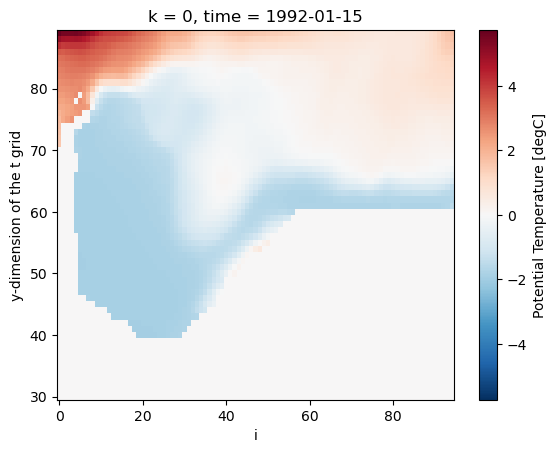

In [16]:
ds.THETA[0,0].drop('i').plot()

In [17]:
drhodt = fastjmd95.drhodt(ds.SALT, ds.THETA, pref)
drhodt

,Array,Chunk
Bytes,626.22 MiB,1.53 MiB
Shape,"(288, 50, 60, 95)","(1, 50, 60, 67)"
Count,68 Graph Layers,576 Chunks
Type,float64,numpy.ndarray


## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial \theta} \dot \theta \end{equation*} </font>

In [18]:
ds_sig_theta = (drhodt * ds_tmp_wg)#.chunk({'XC':-1, 'YC':-1, 'Z':-1, 'time':1})

In [19]:
ds_sig_theta

,Array,Chunk
Bytes,626.22 MiB,1.53 MiB
Shape,"(288, 50, 60, 95)","(1, 50, 60, 67)"
Count,73 Graph Layers,576 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,626.22 MiB,1.53 MiB
Shape,"(288, 50, 60, 95)","(1, 50, 60, 67)"
Count,73 Graph Layers,576 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [20]:
rhs_theta = (ds_sig_theta.conv_horiz_adv_flux_TH+ 
              ds_sig_theta.conv_horiz_diff_flux_TH + 
              ds_sig_theta.conv_vert_adv_flux_TH +
              ds_sig_theta.conv_vert_diff_flux_TH + 
              ds_sig_theta.surface_flux_conv_TH + 
              ds_sig_theta.sw_flux_conv_TH)#.load()

lhs_theta = ds_sig_theta.total_tendency_TH_truth#.load()

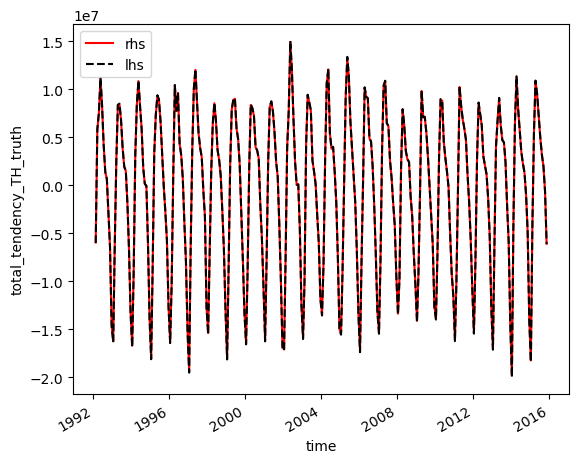

In [21]:
#checking equality
rhs_theta[1:-1].sum(['i', 'j', 'k']).plot(label='rhs', color='r')
lhs_theta[1:-1].sum(['i', 'j', 'k']).plot(label='lhs', color='k', linestyle='--')
plt.legend();

In [22]:
(rhs_theta-lhs_theta).sum(['i', 'j', 'k']).mean('time').values / 1e6 

0.010692865585875094

In [23]:
rhs_vars = [dvar for dvar in ds_sig_theta.data_vars
            if dvar != 'total_tendency_TH_truth']
total_tendency_check = sum([ds_sig_theta[dvar] for dvar in rhs_vars])
total_tendency_check

,Array,Chunk
Bytes,626.22 MiB,1.53 MiB
Shape,"(288, 50, 60, 95)","(1, 50, 60, 67)"
Count,106 Graph Layers,576 Chunks
Type,float64,numpy.ndarray


In [24]:
mask = coords.hFacC[0] > 0

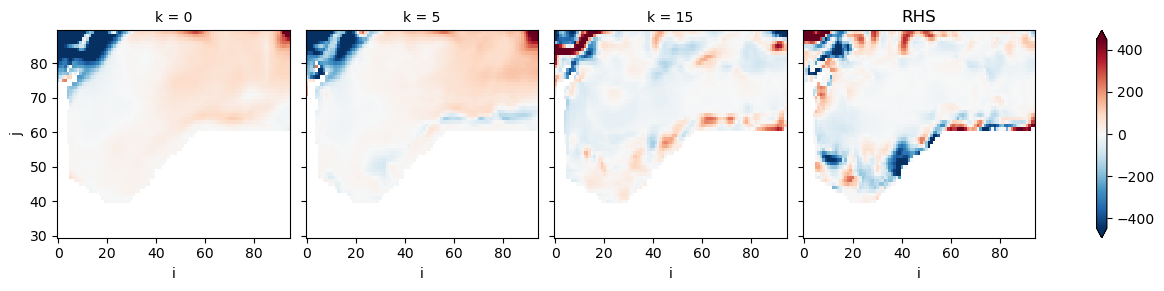

In [25]:
total_tendency_check.isel(time=200, k=[0, 5, 15, 20]).where(mask).drop('i').plot(robust=True, col='k')
plt.title('RHS');

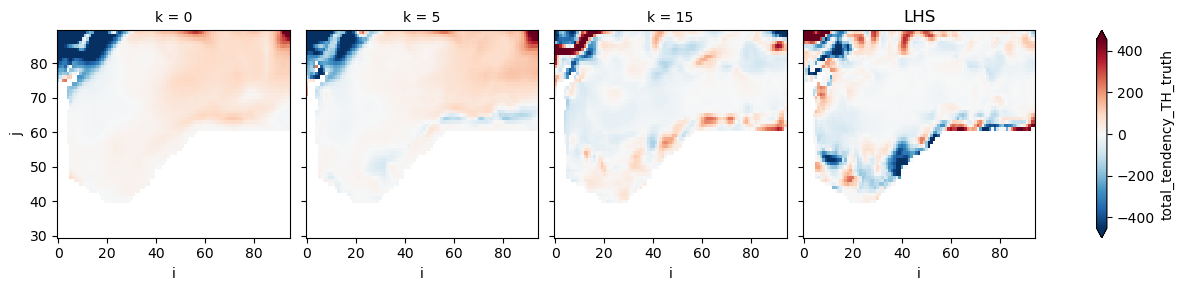

In [26]:
ds_sig_theta.total_tendency_TH_truth.isel(time=200, k=[0, 5, 15, 20]).where(mask).drop('i').plot(robust=True, col='k')
plt.title('LHS');

# <font color='Green'> \begin{equation*} Salinity \end{equation*} </font>

## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial S} \end{equation*} </font>

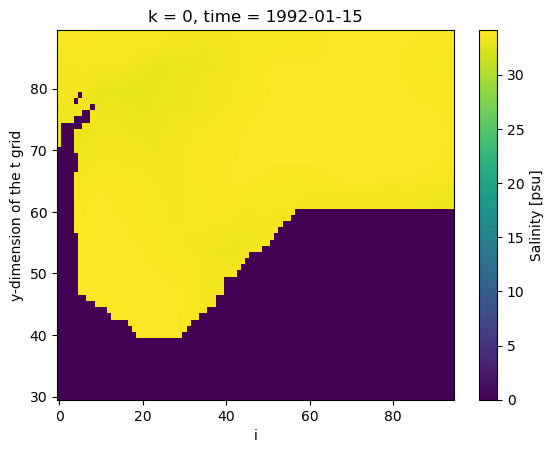

In [27]:
ds.SALT[0,0].drop('i').plot()

In [28]:
drhods = fastjmd95.drhods(ds.SALT, ds.THETA, pref)
drhods

,Array,Chunk
Bytes,626.22 MiB,1.53 MiB
Shape,"(288, 50, 60, 95)","(1, 50, 60, 67)"
Count,68 Graph Layers,576 Chunks
Type,float64,numpy.ndarray


## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial S} \dot S \end{equation*} </font>

In [30]:
ds_sig_salt = (drhods * ds_slt_wg)#.chunk({'XC':-1, 'YC':-1, 'Z':-1, 'time':1})

In [31]:
ds_sig_salt

,Array,Chunk
Bytes,626.22 MiB,1.53 MiB
Shape,"(288, 50, 60, 95)","(1, 50, 60, 67)"
Count,72 Graph Layers,576 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,626.22 MiB,1.53 MiB
Shape,"(288, 50, 60, 95)","(1, 50, 60, 67)"
Count,72 Graph Layers,576 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [32]:
rhs_salt = (ds_sig_salt.conv_adv_flux_SLT + 
              ds_sig_salt.conv_diff_flux_SLT + 
              ds_sig_salt.surface_flux_SLT)#.load()

lhs_salt = ds_sig_salt.total_tendency_SLT_truth#.load()

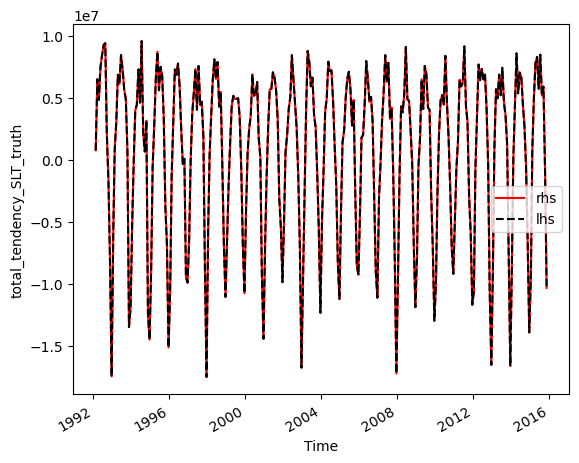

In [33]:
#checking equality
rhs_salt[1:-1].sum(['i', 'j', 'k']).plot(label='rhs', color='r')
lhs_salt[1:-1].sum(['i', 'j', 'k']).plot(label='lhs', color='k', linestyle='--')
plt.legend();

In [34]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.d791c32f5ffc45e6a581f27598fff4b5/status,


In [35]:
(rhs_salt-lhs_salt).sum(['i', 'j', 'k']).mean('time').values / 1e6 

5.8875652264315816e-05

In [36]:
rhs_vars = [dvar for dvar in ds_sig_salt.data_vars
            if dvar != 'total_tendency_TH_truth']
total_tendency_check = sum([ds_sig_salt[dvar] for dvar in rhs_vars])
total_tendency_check

,Array,Chunk
Bytes,626.22 MiB,1.53 MiB
Shape,"(288, 50, 60, 95)","(1, 50, 60, 67)"
Count,100 Graph Layers,576 Chunks
Type,float64,numpy.ndarray


In [37]:
mask = coords.hFacC[0] > 0

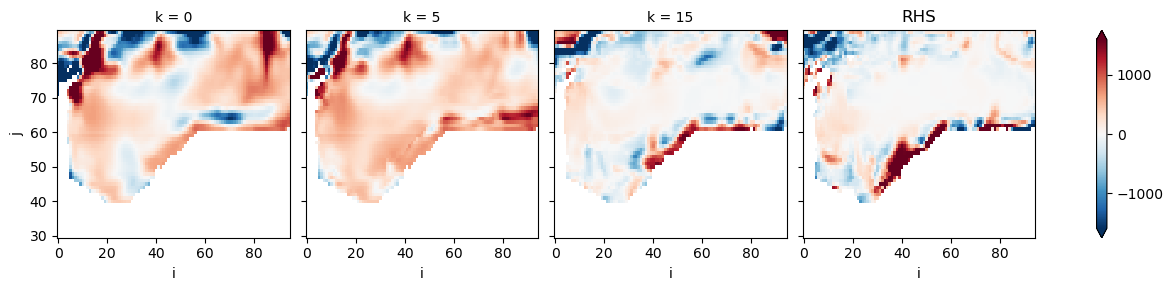

In [38]:
total_tendency_check.isel(time=200, k=[0, 5, 15, 20]).where(mask).drop('i').plot(robust=True, col='k')
plt.title('RHS');

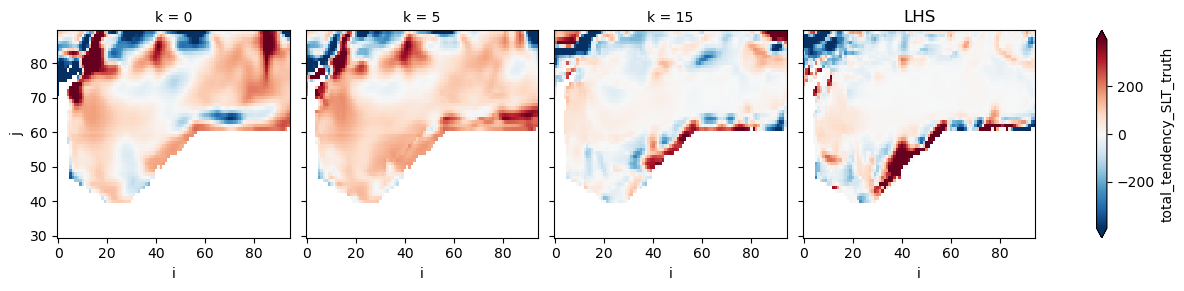

In [39]:
ds_sig_salt.total_tendency_SLT_truth.isel(time=200, k=[0, 5, 15, 20]).where(mask).drop('i').plot(robust=True, col='k')
plt.title('LHS');

## Saving Data

- `drhodt` / `drhods`
- `ds_tmp_wg` / `ds_slt_wg` (rolled and wg slice)
- `ds_sig_theta` / `ds_sig_salt`

In [40]:
drhodts = xr.Dataset({'drhodt':(['time', 'k', 'j', 'i'], drhodt.data), 
                      'drhods':(['time', 'k', 'j', 'i'], drhods.data)}, 
                     coords=dict(time=ds_tmp_wg.time, Z=ds_tmp_wg.k, YC=ds_tmp_wg.j, XC=ds_tmp_wg.i))

In [41]:
drhodts

,Array,Chunk
Bytes,626.22 MiB,1.53 MiB
Shape,"(288, 50, 60, 95)","(1, 50, 60, 67)"
Count,68 Graph Layers,576 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,626.22 MiB,1.53 MiB
Shape,"(288, 50, 60, 95)","(1, 50, 60, 67)"
Count,68 Graph Layers,576 Chunks
Type,float64,numpy.ndarray


In [43]:
ds_slt_wg = ds_slt_wg.drop(('G_adv', 'G_adv_conv', 'G_diff', 'G_forc', 'G_tot'))

In [45]:
ds_tmp_slt_wg = xr.merge([ds_tmp_wg, ds_slt_wg])

In [46]:
ds_tmp_slt_wg

,Array,Chunk
Bytes,313.11 MiB,1.09 MiB
Shape,"(288, 50, 60, 95)","(1, 50, 60, 95)"
Count,3 Graph Layers,288 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,313.11 MiB,1.09 MiB
Shape,"(288, 50, 60, 95)","(1, 50, 60, 95)"
Count,3 Graph Layers,288 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [47]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [49]:
#saving temperature component -> drho/dtheta * dtheta/dtime
gcsmap_sig_theta = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/ECCO/ds_sig_theta_wg.zarr')
ds_sig_theta.to_zarr(gcsmap_sig_theta, mode='w')

In [50]:
#saving salt component -> drho/dsalt * dsalt/time
gcsmap_sig_salt = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/ECCO/ds_sig_salt_wg.zarr')
ds_sig_salt.to_zarr(gcsmap_sig_salt, mode='w')

In [51]:
#saving drhodt and drhods
gcsmap_drhodts = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/ECCO/drhodts_wg.zarr')
drhodts.to_zarr(gcsmap_drhodts, mode='w')

In [52]:
#saving rolled ds_tmp_wg and ds_slt_wg
gcsmap_ds_tmp_slt_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/ECCO/ds_tmp_slt_wg.zarr')
ds_tmp_slt_wg.to_zarr(gcsmap_ds_tmp_slt_wg, mode='w')

In [7]:
ds_tns = xr.merge([ds.THETA, ds.THETA_snp, ds.SALT, ds.SALT_snp])

In [8]:
#saving rolled theta and salt
gcsmap_ds_tmp_slt_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/ECCO/ds_tns_wg.zarr')
ds_tns.to_zarr(gcsmap_ds_tmp_slt_wg, mode='w')

In [56]:
#saving rolled coords_wg
gcsmap_coords_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/ECCO/coords_wg.zarr')
coords.to_zarr(gcsmap_coords_wg, mode='w')

In [13]:
ds_vel = xr.merge([ds.UVELMASS, ds.UVELSTAR, ds.VVELMASS, ds.VVELSTAR])

In [16]:
#saving rolled velocities
gcsmap_vel_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/ECCO/ds_vel_wg.zarr')
ds_vel.to_zarr(gcsmap_vel_wg, mode='w')